In [2]:
from keras.layers import Input, Lambda, Dense, Flatten, Dropout, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import time
from keras.regularizers import  l2
IMAGE_SIZE = [224,224]

validation_path = '/kaggle/input/flower-histogram-dataset/validation'
training_path = '/kaggle/input/flower-histogram-dataset/train'


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam

# Load the InceptionV3 model pre-trained on ImageNet dataset
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of all layers except the last few
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Add a global average pooling layer and output layer for jujube species classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(0.1)(x)
predictions = Dense(units=5, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with categorical cross-entropy loss and Adam optimizer
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

# Print the model summary
model.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     

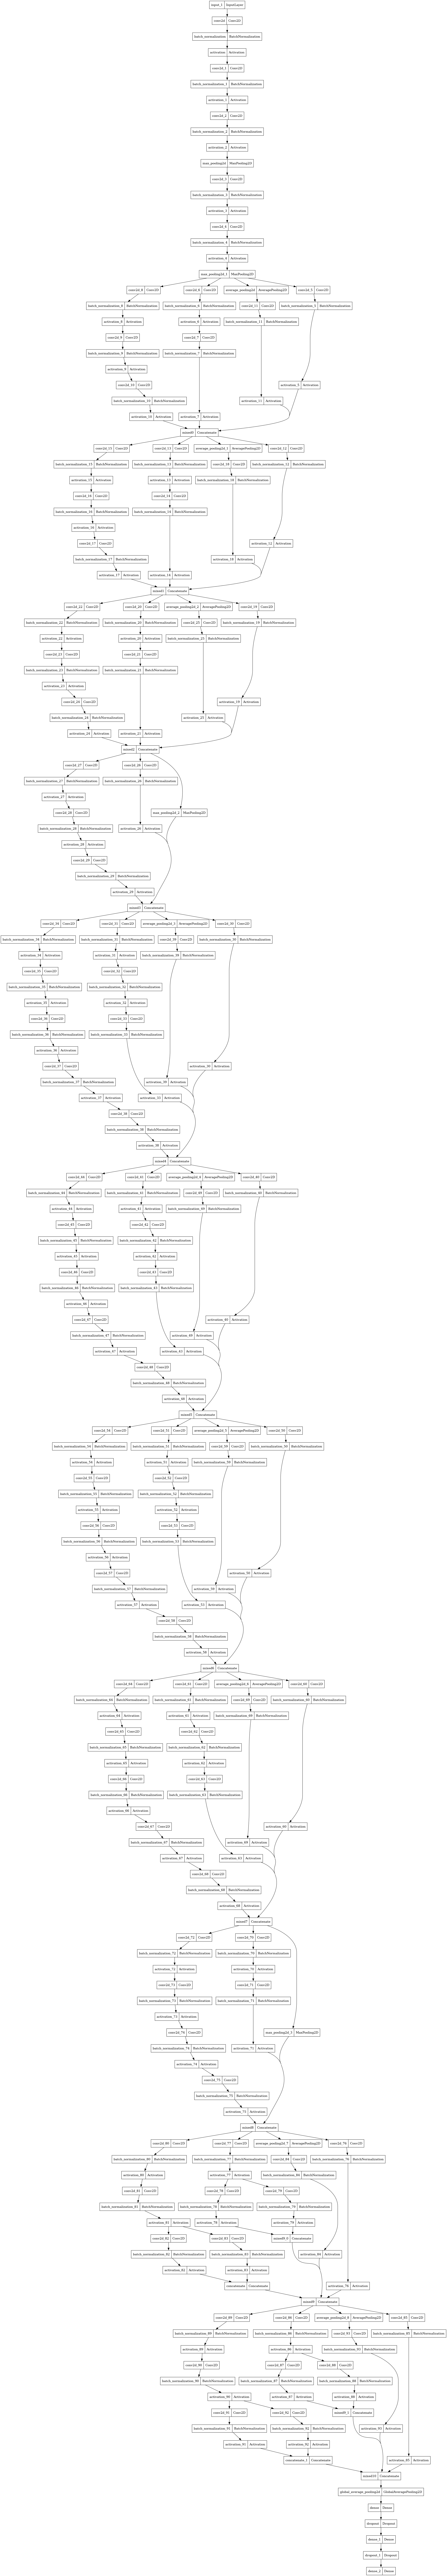

In [4]:
from keras.utils import plot_model
plot_model(model,to_file = "model_3_InceptionV3.png")

In [5]:
model.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])

train_datagen =  ImageDataGenerator(
    rescale = 1./255,
)
test_datagen = ImageDataGenerator(
    rescale = 1./255
)

train_dataset = train_datagen.flow_from_directory(training_path,target_size = (224,224),batch_size = 32,)
validation_dataset = test_datagen.flow_from_directory(validation_path,target_size = (224,224),batch_size = 32,)


Found 3540 images belonging to 5 classes.
Found 80 images belonging to 5 classes.


In [6]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("model_3_InceptionV3.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=25, verbose=1, mode='max')

In [7]:
s = time.time()
history = model.fit(
    train_dataset,
    validation_data = validation_dataset,
    epochs = 30,
    steps_per_epoch = len(train_dataset),
    validation_steps = len(validation_dataset),
    verbose=1,
    callbacks=[checkpoint,early],
    shuffle=True,
    workers = 5
)

Epoch 1/30
111/111 [==============================] - ETA: 0s - loss: 0.8858 - accuracy: 0.6559
Epoch 1: val_accuracy improved from -inf to 0.82500, saving model to model_3_InceptionV3.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


111/111 [==============================] - 27s 118ms/step - loss: 0.8858 - accuracy: 0.6559 - val_loss: 0.5789 - val_accuracy: 0.8250
Epoch 2/30
111/111 [==============================] - ETA: 0s - loss: 0.5901 - accuracy: 0.7808
Epoch 2: val_accuracy improved from 0.82500 to 0.83750, saving model to model_3_InceptionV3.h5
111/111 [==============================] - 9s 78ms/step - loss: 0.5901 - accuracy: 0.7808 - val_loss: 0.5681 - val_accuracy: 0.8375
Epoch 3/30
111/111 [==============================] - ETA: 0s - loss: 0.5261 - accuracy: 0.7997
Epoch 3: val_accuracy did not improve from 0.83750
111/111 [==============================] - 8s 73ms/step - loss: 0.5261 - accuracy: 0.7997 - val_loss: 0.6253 - val_accuracy: 0.7625
Epoch 4/30
111/111 [==============================] - ETA: 0s - loss: 0.4691 - accuracy: 0.8246
Epoch 4: val_accuracy did not improve from 0.83750
111/111 [==============================] - 8s 72ms/step - loss: 0.4691 - accuracy: 0.8246 - val_loss: 0.4828 - val_ac

In [9]:
print("time taken: ",time.time()-s)

time taken:  258.3498673439026


3/3 [==============================] - 0s 97ms/step


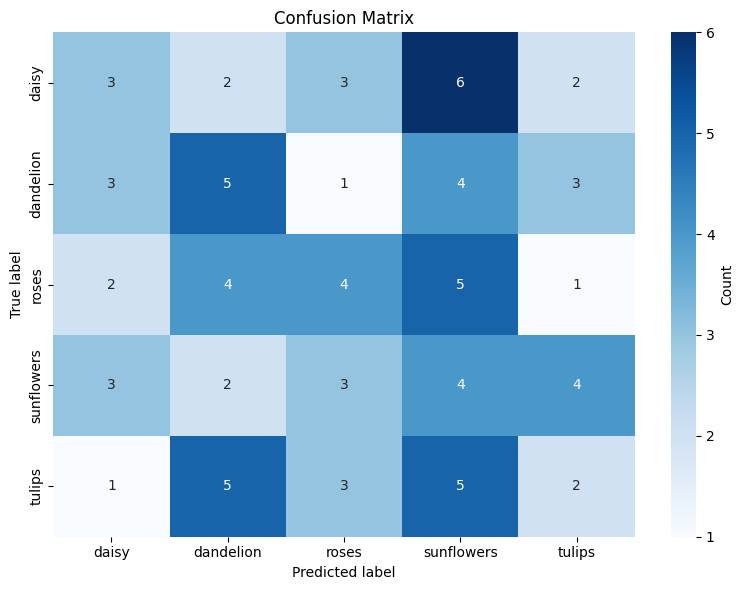

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# ... (your existing code for model training and validation data setup)

# Predictions
y_pred = model.predict(validation_dataset)
y_pred = np.argmax(y_pred, axis=1)

# True labels
y_true = validation_dataset.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Define class names
class_names = list(validation_dataset.class_indices.keys())

# Plot Confusion Matrix
def plot_confusion_matrix(conf_matrix, target_names, title='Confusion Matrix', cmap=None, normalize=True):
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap=cmap, cbar_kws={'label': 'Count'})

    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.xticks(ticks=np.arange(len(target_names)) + 0.5, labels=target_names)
    plt.yticks(ticks=np.arange(len(target_names)) + 0.5, labels=target_names)

    if normalize:
        conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    plt.tight_layout()
    plt.show()

# Plot Confusion Matrix
plot_confusion_matrix(cm, class_names, title='Confusion Matrix', cmap='Blues', normalize=True)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


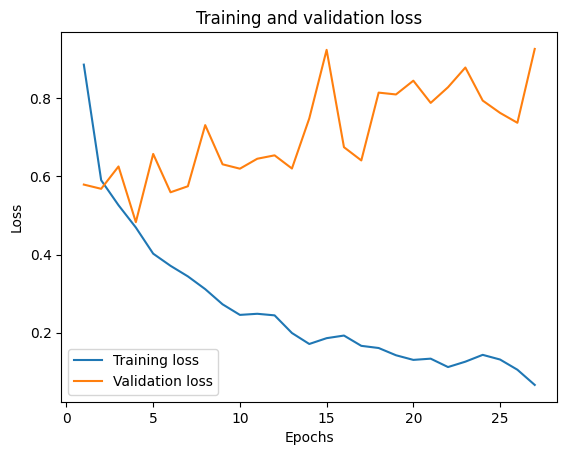

In [11]:
history_dict = history.history
print(history_dict.keys())
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc = history_dict['accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss_values, label="Training loss")
plt.plot(epochs, val_loss_values, label='Validation loss')
plt.title("Training and validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

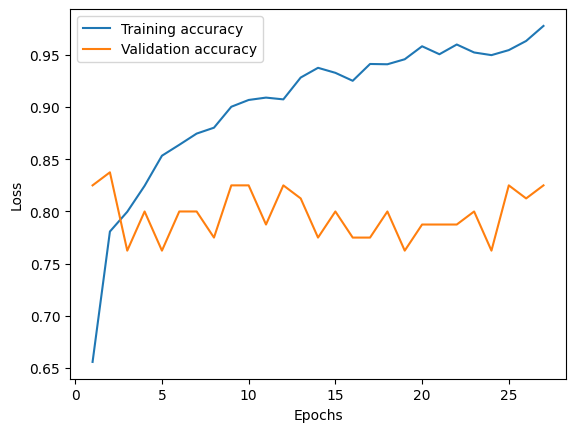

In [12]:
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
import pandas as pd
his_df = pd.DataFrame(history_dict)

In [14]:
his_df.to_excel('model_3_InceptionV3.xlsx',index=False)

In [15]:
from sklearn.metrics import classification_report

# Calculate classification report
classification_rep = classification_report(y_true, y_pred, target_names=class_names)

# Print and display the classification report
print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

       daisy       0.25      0.19      0.21        16
   dandelion       0.28      0.31      0.29        16
       roses       0.29      0.25      0.27        16
  sunflowers       0.17      0.25      0.20        16
      tulips       0.17      0.12      0.14        16

    accuracy                           0.23        80
   macro avg       0.23      0.23      0.22        80
weighted avg       0.23      0.23      0.22        80

